# Predykcja ataku phishingowego w wiadomości <b>e-mail</b> za pomocą <b><i>nadzorowanego nauczania maszynowego</i></b>
Dataset: 
<ul>
    <li><i><b>Phishing Email Curated Datasets</b></i></li>
    <ul>
        <li><a href="https://zenodo.org/records/8339691" target="_blank">https://zenodo.org/records/8339691</a></li>
    </ul>
</ul>

### Pobieranie niezbędnych modułów
<ul>
    <li> pandas - praca z <i>Data Framami</i></li>
    <li> numpy - obliczenia</li>
    <li> matplotlib.pyplot - wizualizacja</li>
    <li> sklearn - wszelakie narzędzia do <i>Machine Learningu</i></li>
</ul>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import import_ipynb

### Wczytanie uprzednio przygotowanego Data Framu

In [2]:
learning_set = pd.read_csv('ML_DataFrame.csv')
print(learning_set.head())

   Unnamed: 0  label  urls_count  protocol  contains_ip  url_length  \
0           0    1.0         1.0       0.0          0.0        21.0   
1           1    1.0         1.0       0.0          0.0        25.0   
2           2    1.0         3.0       0.0          0.0       110.0   
3           3    0.0         3.0       0.0          0.0        22.0   
4           4    1.0         1.0       0.0          0.0       136.0   

   TLD_alpha  subdomain_level  slash_count  dots_count  hyphens_count  \
0        1.0              0.0          3.0         1.0            0.0   
1        1.0              1.0          2.0         2.0            0.0   
2        1.0              1.0          6.0         5.0            0.0   
3        0.0              1.0          2.0         2.0            0.0   
4        1.0              2.0          4.0         4.0            2.0   

   has_non_latin  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  


In [3]:
print(learning_set.isna().sum())
learning_set.dropna(inplace=True)

Unnamed: 0          0
label               0
urls_count          0
protocol            0
contains_ip         0
url_length          0
TLD_alpha           0
subdomain_level    84
slash_count         0
dots_count          0
hyphens_count       0
has_non_latin       0
dtype: int64


### Wybieranie X i y
X:
<ul>
<li> urls_count </li>
<li>protocol </li>
<li> contains_ip </li>
<li> url_length </li>
<li> TLD_alpha </li>
<li> subdomain_level </li>
<li> slash_count </li>
<li> dots_count </li>
<li> hyphens_count </li>
<li> has_non_latin </li>
</ul>
y:
<ul>
    <li> label </li>
</ul>

In [4]:
X = learning_set.loc[:, 'urls_count':'has_non_latin'].values
y = learning_set.loc[: , 'label'].values
print(X.shape, y.shape)

(41632, 10) (41632,)


### Rozdzielanie X, y na treningowe i testowe zestawy

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Normalizujemy wartość <b><i>X</i></b>-ów

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(33305, 10) (8327, 10) (33305,) (8327,)


### Szukanie najlepszych parametrów dla <i>KNeighborsClassifier</i>


In [8]:
kf = KFold(n_splits=6, shuffle=True, random_state=42)
params = {
    'n_neighbors': np.arange(1, 15, 1),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid=params, cv=kf)
knn_cv.fit(X_train, y_train)

print('Najlepsze parametry dla KNeighborsClassifier:')
for p, val in knn_cv.best_params_.items():
    print('{}: {}'.format(p, val), end='\n')
print('Uzyskana precyzja: ', knn_cv.best_score_)

best_knn = knn_cv.best_estimator_
test_accuracy = best_knn.score(X_test, y_test)
print("Precyzja zestawu testowego:", test_accuracy)



Najlepsze parametry dla KNeighborsClassifier:
n_neighbors: 13
p: 1
weights: distance
Uzyskana precyzja:  0.8729022068366331
Precyzja zestawu testowego: 0.8734238020895881


In [20]:
from sklearn.linear_model import LogisticRegression
kf = KFold(n_splits=6, shuffle=True, random_state=42)
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10] 
}
logreg_forest = LogisticRegression()
logreg_cv = GridSearchCV(logreg_forest, param_grid=params, cv=kf)
logreg_cv.fit(X_train, y_train)

print('Najlepsze parametry dla LogisticRegression:')
for p, val in logreg_cv.best_params_.items():
    print('{}: {}'.format(p, val), end='\n')
print('Uzyskana precyzja: ', logreg_cv.best_score_)

best_logreg = logreg_cv.best_estimator_
test_accuracy = best_logreg.score(X_test, y_test)
print("Precyzja zestawu testowego:", test_accuracy)

Najlepsze parametry dla LogisticRegression:
C: 10
penalty: l2
Uzyskana precyzja:  0.7300107493550115
Precyzja zestawu testowego: 0.7341179296265161


C:\Users\Patryk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Patryk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Patryk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-p

### Szukanie najlepszych parametrów dla <i>DecisionTreeClassifier</i>

In [9]:
kf = KFold(n_splits=6, shuffle=True, random_state=42)
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]  
}
tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, param_grid=params, cv=kf)
tree_cv.fit(X_train, y_train)

print('Najlepsze parametry dla DecisionTreeClassifier:')
for p, val in tree_cv.best_params_.items():
    print('{}: {}'.format(p, val), end='\n')
print('Uzyskana precyzja: ', tree_cv.best_score_)

best_tree = tree_cv.best_estimator_
test_accuracy = best_tree.score(X_test, y_test)
print("Precyzja zestawu testowego:", test_accuracy)

Najlepsze parametry dla KNeighborsClassifier:
criterion: gini
max_depth: None
min_samples_leaf: 1
min_samples_split: 2
Uzyskana precyzja:  0.8710406479258938
Precyzja zestawu testowego: 0.8706617028941996


### Szukanie najlepszych parametrów dla <i>RandomForestClassifier</i>

In [18]:
from sklearn.ensemble import RandomForestClassifier

kf = KFold(n_splits=6, shuffle=True, random_state=42)
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4] 
}
rand_forest = RandomForestClassifier()
rand_forest_cv = GridSearchCV(rand_forest, param_grid=params, cv=kf)
rand_forest_cv.fit(X_train, y_train)

print('Najlepsze parametry dla RandomForestClassifier:')
for p, val in rand_forest_cv.best_params_.items():
    print('{}: {}'.format(p, val), end='\n')
print('Uzyskana precyzja: ', rand_forest_cv.best_score_)

best_rand_forest = rand_forest_cv.best_estimator_
test_accuracy = best_rand_forest.score(X_test, y_test)
print("Precyzja zestawu testowego:", test_accuracy)

Najlepsze parametry dla RandomForestClassifier:
max_depth: None
min_samples_leaf: 1
min_samples_split: 10
n_estimators: 50
Uzyskana precyzja:  0.8761749120765514
Precyzja zestawu testowego: 0.8727032544733998


### Szukanie najlepszych parametrów dla <i>SVM Classifier</i>

In [21]:
from sklearn.svm import SVC

kf = KFold(n_splits=6, shuffle=True, random_state=42)
params = {
    'C': [0.1, 1, 10], 
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1, 1]
}
svm = SVC()
svm_cv = GridSearchCV(svm, param_grid=params, cv=kf)
svm_cv.fit(X_train, y_train)

print('Najlepsze parametry dla RandomForestClassifier:')
for p, val in svm_cv.best_params_.items():
    print('{}: {}'.format(p, val), end='\n')
print('Uzyskana precyzja: ', svm_cv.best_score_)

best_svm = svm_cv.best_estimator_
test_accuracy = best_svm.score(X_test, y_test)
print("Precyzja zestawu testowego:", test_accuracy)

Najlepsze parametry dla RandomForestClassifier:
C: 10
gamma: 1
kernel: rbf
Uzyskana precyzja:  0.8508033776886236
Precyzja zestawu testowego: 0.8576918458028101


### Walidacja wybranych modeli

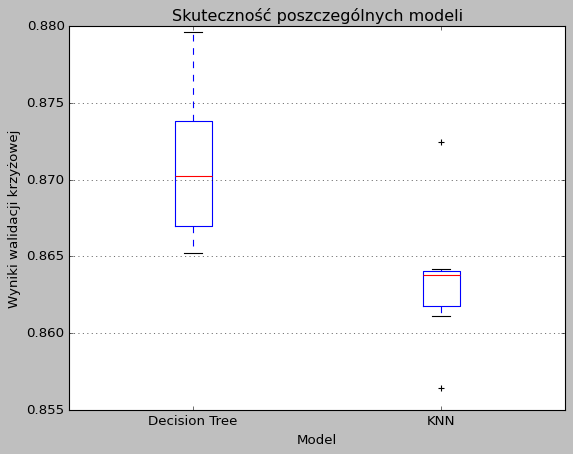

In [11]:
# plt.style.use('classic')
# fig, ax = plt.subplots()

# ax.boxplot(results, labels=models.keys())
# ax.set_title('Skuteczność poszczególnych modeli')
# ax.set_xlabel('Model')
# ax.set_ylabel('Wyniki walidacji krzyżowej')
# #ax.set_ylim(0.7, 1)
# plt.grid(axis='y', visible=True)
# plt.show()

In [12]:
# tree_mean = np.round(results[0].mean(), 4)
# knn_mean = np.round(results[1].mean(), 4)
# tree_std = np.round(results[0].std(), 4)
# knn_std = np.round(results[1].std(), 4)
# print('Precyzje:\n- Decision Tree: {}\n- KNN: {}'.format(tree_mean, knn_mean))
# print('Odchylenia standardowe:\n- Decision Tree: {}\n- KNN: {}'.format(tree_std, knn_std))

Precyzje:
- Decision Tree: 0.871
- KNN: 0.8636
Odchylenia standardowe:
- Decision Tree: 0.005
- KNN: 0.0048


### Nauczanie najskuteczniejszego modelu
Najlepszy okazał się <b><i>DecisionTreeClassifier</i></b>
<ul>
    <li>Accuracy ~0.87 &plusmn; 0.0045</li>
</ul>

In [13]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

### Walidacja modelu

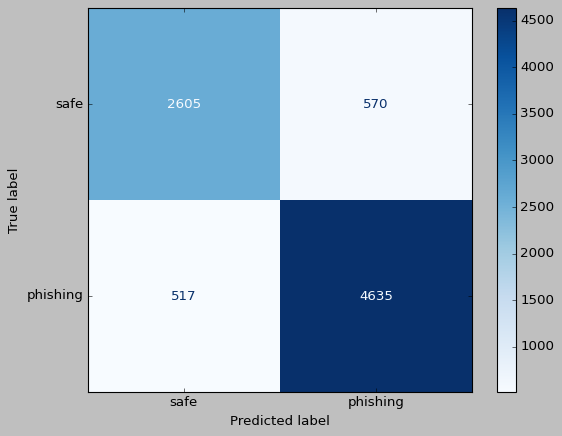

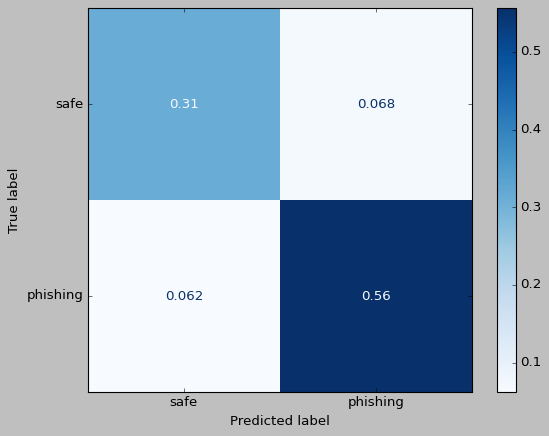

In [14]:
y_pred = tree.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# Wartości bezwzględne
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix,
    display_labels=['safe', 'phishing'])

cm_display.plot(cmap='Blues')
plt.show()

# Wartości względne
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix/np.sum(confusion_matrix),
    display_labels=['safe', 'phishing'])
    
cm_display.plot(cmap='Blues')
plt.show()

In [15]:
target_names = ['safe', 'phishing']
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        safe       0.83      0.82      0.83      3175
    phishing       0.89      0.90      0.90      5152

    accuracy                           0.87      8327
   macro avg       0.86      0.86      0.86      8327
weighted avg       0.87      0.87      0.87      8327



### Test na przykładzie z żyćka

In [16]:
mail_example = {
'sender': 'Marcin Sawiński <Marcin.Sawinski@ue.poznan.pl>',
'subject': 'Projekty zaliczeniowe z PSI',
'body': '''
        Drodzy Studenci,

        Chciałbym Was prosić o zapisanie w arkuszu tematów projektów zaliczeniowych oraz wskazanie osób w zespołach (numer teamu            przy nazwisku).

        https://uniekonpoznan.sharepoint.com/:x:/s/AI_2023_2024/EQ5avb31cRpAliTAmGtxQ1gB5_YtB0YJTh3c9t7n30uLdQ?e=yLzaTU

        Pozdrawiam,

        Marcin Sawinski
        --
        Wiadomość wysłana przez system USOS.
        Łączna liczba adresatów tej wiadomości: 117

        Nadawcą korespondencji i jednocześnie administratorem Państwa danych osobowych jest Uniwersytet Ekonomiczny w Poznaniu,             al. Niepodległości 10, 61-875 Poznań, z którym można skontaktować się listownie lub poprzez wiadomość e-mail (rodo@ue.poznan.pl)       Państwa dane osobowe przetwarzane będą w celu prowadzenia niniejszej korespondencji i przez czas jej trwania. Przysługuje           Państwu prawo dostępu do danych, ich sprostowania, ograniczenia przetwarzania, usunięcia, żądania sprzeciwu wobec                   przetwarzania oraz wniesienia skargi do Prezesa Urzędu Ochrony Danych Osobowych. Szczegółowe informacje na temat ochrony            danych osobowych dostępne są w Polityce prywatności.
'''
}
#TODO: DOKOŃCZYĆ

# Rezultat projektu
Przy pomocy <b><i>DecisionTreeClassifier</i></b> udało się wytrenować model z wynikami:
<ul>
    <li> (accuracy) ~     </li>   
    <li> (recall) ~       </li>
    <li> (F1) ~       </li>
</ul>
</br>
Problemy podczas projektu
<ul>
    <li> dostęp do API </li>
    <ul>
        <li> brak sprawdzania domen w blacklistach </li>
        <li> brak sprawdzania adresów e-mail w blacklistach </li>
        <li> słabe/brak informacji o szyfrowaniu SSL </li>
        <li> brak sprawdzania wieku domeny
    </ul>
    <li> Dane zbierane w latach 2008-2022 </li>
    <li> Człowiek minimalnie obeznany w internecie </br>poradziłby sobie z klasyfikowaniem ataków phishingowych z datasetu.

</ul>